<a href="https://colab.research.google.com/github/emmanuel-olateju/atari_pingpong/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir environments
!wget https://raw.githubusercontent.com/emmanuel-olateju/atari_pingpong/main/environments/__init__.py
!mv __init__.py environments/
!wget https://raw.githubusercontent.com/emmanuel-olateju/atari_pingpong/main/environments/atari_environments.py
!mv atari_environments.py environments/

!mkdir DQN_training_sessions

--2024-05-11 10:19:37--  https://raw.githubusercontent.com/emmanuel-olateju/atari_pingpong/main/environments/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66 [text/plain]
Saving to: ‘__init__.py’

__init__.py         100%[===================>]      66  --.-KB/s    in 0s      

2024-05-11 10:19:37 (1.00 MB/s) - ‘__init__.py’ saved [66/66]

--2024-05-11 10:19:37--  https://raw.githubusercontent.com/emmanuel-olateju/atari_pingpong/main/environments/atari_environments.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35

In [2]:
import os
import random
import numpy as np
import joblib
import torch
import torch.nn as nn
import importlib
from itertools import product

from environments import atari_environments
importlib.reload(atari_environments)

seed = 100

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
ENVIRONMENT_HEIGHT, ENVIRONMENT_WIDTH = 600, 840
PADDLE_HEIGHT, PADDLE_WIDTH = 110, 10
BALL_SIZE = 10

env_params = {
    "HEIGHT":ENVIRONMENT_HEIGHT,
    "WIDTH":ENVIRONMENT_WIDTH,
    "PADDLE_HEIGHT":PADDLE_HEIGHT,
    "PADDLE_WIDTH":PADDLE_WIDTH,
    "BALL_SIZE":10,
    "BALL_SPEED":(random.choice([-7,7]),random.choice([-7,7])),
    "MISS_REWARD":-5,
    "HIT_REWARD":10,
    "PASSIVE_REWARD":1
}
env = atari_environments.pong_env(**env_params)

## Approximate Q Learning

#### Functions

In [4]:
def aqn_set_state(environment):
  # set __yp__ (y position of paddle)
  if environment.agent.top>=0 and environment.agent.top<(environment.HEIGHT//5):
      __yp__ = 0
  elif environment.agent.top<=(2*(environment.HEIGHT//5)):
      __yp__ = 1
  elif environment.agent.top<=(3*(environment.HEIGHT/5)):
      __yp__ = 3
  elif environment.agent.top<=(4*(environment.HEIGHT//5)):
      __yp__ = 3
  else:
      __yp__ = 4

  # set __xb__ (x position of ball)
  if environment.ball.right>=0 and environment.ball.right<(environment.WIDTH//5):
      __xb__ = 0
  elif environment.ball.right<=(2*(environment.WIDTH//5)):
      __xb__ = 1
  elif environment.ball.right<=(3*(environment.WIDTH//5)):
      __xb__ = 2
  elif environment.ball.right<=(4*(environment.WIDTH//5)):
      __xb__ = 3
  else:
      __xb__ = 4

  # set __yb__ (y position of the ball)
  if environment.ball.top>=0 and environment.ball.top<(environment.HEIGHT//5):
      __yb__ = 0
  elif environment.ball.top<=(2*(environment.HEIGHT//5)):
      __yb__ = 1
  elif environment.ball.top<=(3*(environment.HEIGHT//5)):
      __yb__ = 2
  elif environment.ball.top<=(4*(environment.HEIGHT//5)):
      __yb__ = 3
  else:
      __yb__ = 4

  # set __bxv__ (x velocity of ball)
  if environment.BALL_SPEED_X>0:
      __bxv__ = 1
  else:
      __bxv__ = 0

  # set __byv__ (y velocity of ball)
  if environment.BALL_SPEED_Y>0:
      __byv__ = 1
  else:
      __byv__ = 0

  __xb__ = float(__xb__)
  __yb__ = float(__yb__)
  __yp__ = float(__yp__)
  __bxv__ = float(__bxv__)
  __byv__ = float(__byv__)

  return (__xb__, __yb__, __yp__, __bxv__, __byv__)

def epsilon_greedy_selection(environment,cycle,state,eps_min,eps_max,eps_decay_steps):
  epsilon= max(eps_min, eps_max - (eps_max-eps_min) * cycle/eps_decay_steps)
  if (state[0]<=__xth__) and (state[3]==0):
    if abs(state[1]-state[2])<=__yth__:
        n = random.random()
        if n <= epsilon:
            action_index = random.randint(0,len(environment.__ACTION_SPACE__)-1)
        else:
            q = __states__.index(state)
            q = Q_optimal[q,:]
            action_index = np.argmax(q)
    else:
        action_index = random.randint(0,len(environment.__ACTION_SPACE__)-1)
  else:
    action_index = 2
  return action_index, epsilon

def checkpoint_aqn_model(name,Q_optimal,history,file_dir,file_name,epsilon_tuple,reward_tuple,alpha,gamma,no_cycles,
                     hits_epoch,rewards_epoch):
  model = {
      "name":name,
      "Q_mat":Q_optimal,
      "history":history,
      "PARAMS":{
          "epsilon": epsilon_tuple,
          "reward": reward_tuple,
          "alpha":alpha,
          "gamma":gamma,
          "no_cycles":no_cycles,
      },
      "PERFORMANCE":{
          "hits_epoch_slope":hits_epoch,
          "rewards_epoch_slope":rewards_epoch
      }
  }

  joblib.dump(model,file_dir+file_name)


#### Training the Model

In [5]:
# Ball Position Threshold To start Taking Actions
__xth__, __yth__ = 4, 4

# Previous and Current State
prev_state = (0,0,0,0,0)
state = (0,0,0,0,0)

# All Possible States
__states__ = list(product(list(range(0,5)),list(range(0,5)),list(range(0,5)),list(range(0,2)),list(range(0,2))))

# Q values
Q_optimal = np.zeros((len(__states__),len(env.__ACTION_SPACE__)))

# Epsipon Parameters
eps_min, eps_max, eps_decay_steps = 0.3, 0.3, 150



In [6]:
_ = env.reset()
history = {
    "hit_ratio":[],
    "epsilon":[],
    "hits":[],
    "rewards":[]
}

cycle = 1
hits = 0
total_rewards = 0

alpha = 0.3
gamma = 0.1

steps = 0

while cycle<=500:
  prev_state = aqn_set_state(env)
  action_index, epsilon = epsilon_greedy_selection(env,cycle,prev_state,eps_min,eps_max,eps_decay_steps)
  _, action_index, _, reward = env.step(action_index)

  psi = __states__.index(prev_state) # previous state index
  nsi = __states__.index(state) #next/current state index
  Q_optimal[psi,action_index] = Q_optimal[psi,action_index] + alpha*(reward+(gamma*max(Q_optimal[nsi,:]))-Q_optimal[psi,action_index])

  if reward==env.HIT_REWARD or reward==env.MISS_REWARD:
    cycle += 1
    if reward==env.HIT_REWARD:
        hits += 1
    print("-------------------------------------------------------------------------------------")
    print(f"step(sample): {steps} => performance: {hits/cycle:.2f} | epsilon: {epsilon:.2f}")
    print(f"hits: {hits} | no_cycles: {cycle} | rewards: {total_rewards}" )
  total_rewards += reward

  history["hit_ratio"].append(hits/cycle)
  history["epsilon"].append(epsilon)
  history["hits"].append(hits)
  history["rewards"].append(total_rewards)

  steps += 1

checkpoint_aqn_model("aqn",Q_optimal,history,"DQN_training_sessions/","aqn",(eps_min,eps_max,eps_decay_steps),(env.HIT_REWARD,env.MISS_REWARD,env.PASSIVE_REWARD),\
                      alpha,gamma,cycle,history["hits"][-1]/cycle,history["rewards"][-1]/cycle)

-------------------------------------------------------------------------------------
step(sample): 670 => performance: 0.50 | epsilon: 0.30
hits: 1 | no_cycles: 2 | rewards: 1071.8085783333345
-------------------------------------------------------------------------------------
step(sample): 5098 => performance: 0.33 | epsilon: 0.30
hits: 1 | no_cycles: 3 | rewards: 8163.611206666621
-------------------------------------------------------------------------------------
step(sample): 5820 => performance: 0.50 | epsilon: 0.30
hits: 2 | no_cycles: 4 | rewards: 9312.003316666613
-------------------------------------------------------------------------------------
step(sample): 6990 => performance: 0.60 | epsilon: 0.30
hits: 3 | no_cycles: 5 | rewards: 11192.06502499996
-------------------------------------------------------------------------------------
step(sample): 8154 => performance: 0.67 | epsilon: 0.30
hits: 4 | no_cycles: 6 | rewards: 13062.507536666619
-----------------------------

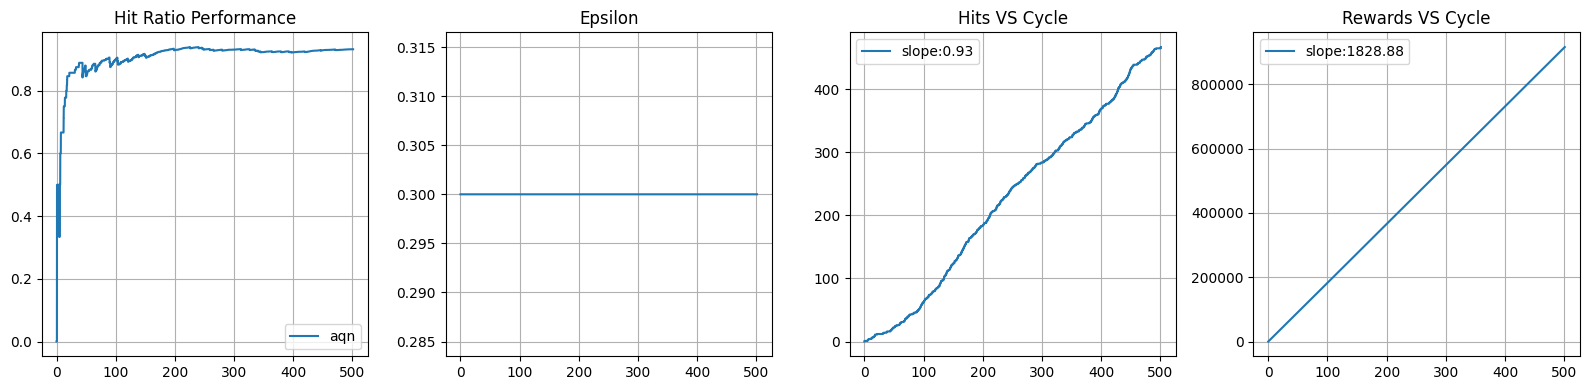

In [7]:
import matplotlib.pyplot as plt

training_dir = "DQN_training_sessions/"
aqn_session = (joblib.load(training_dir+"aqn"))

fig,ax = plt.subplots(1,4,figsize=(16,4))

window_size = ws = int(aqn_session["PARAMS"]["no_cycles"]*0.15)
weights = np.ones(window_size)/window_size

hits_epoch_slope_ = aqn_session["PERFORMANCE"]["hits_epoch_slope"]
rewards_epoch_slope_ = aqn_session["PERFORMANCE"]["rewards_epoch_slope"]
ax.flatten()[0].plot(np.linspace(0,aqn_session["PARAMS"]["no_cycles"],len(aqn_session["history"]["hit_ratio"])),aqn_session["history"]["hit_ratio"],label=aqn_session["name"])
ax.flatten()[1].plot(np.linspace(0,aqn_session["PARAMS"]["no_cycles"],len(aqn_session["history"]["epsilon"])),aqn_session["history"]["epsilon"])
ax.flatten()[2].plot(np.linspace(0,aqn_session["PARAMS"]["no_cycles"],len(aqn_session["history"]["hits"])),aqn_session["history"]["hits"],label=f"slope:{hits_epoch_slope_:.2f}")
ax.flatten()[3].plot(np.linspace(0,aqn_session["PARAMS"]["no_cycles"],len(aqn_session["history"]["rewards"])),aqn_session["history"]["rewards"],label=f"slope:{rewards_epoch_slope_:.2f}")

for i in range(4):
    ax.flatten()[i].grid()

ax.flatten()[0].set_title("Hit Ratio Performance")
ax.flatten()[1].set_title("Epsilon")
ax.flatten()[2].set_title("Hits VS Cycle")
ax.flatten()[3].set_title("Rewards VS Cycle")

ax.flatten()[0].legend()
ax.flatten()[2].legend()
ax.flatten()[3].legend()

fig.tight_layout()

## Deep Q Learning

#### Neural Networks

In [ ]:
class mlp(nn.Module):

    def __init__(self):
        super(mlp,self).__init__()
        self.fc1=nn.Linear(5,3000)
        self.fc1_actv_fn=nn.Sigmoid()
        self.fc2=nn.Linear(3000,3000)
        self.fc2_actv_fn=nn.Sigmoid()
        self.fc3=nn.Linear(3000,300)
        self.fc3_actv_fn=nn.Sigmoid()
        self.out=nn.Linear(300,3)
        self.out_actv_fn=nn.Sigmoid()

    def forward(self,x):
        if ~isinstance(x,torch.Tensor):
            if isinstance(x,(float,list,tuple)):
                x = torch.tensor(x)
        x = self.fc1_actv_fn(self.fc1(x))
        x = self.fc2_actv_fn(self.fc2(x))
        x = self.fc3_actv_fn(self.fc3(x))
        x = self.out(x)
        x = self.out_actv_fn(x)
        return x

class cnn(nn.Module):

    def __init__(self):
        super(cnn,self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1,5,kernel_size=2,stride=1), # Input = 5 | Output = 5*4
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=1), # Input = 5*4 | Output = 5*3
            nn.Conv1d(5,15,kernel_size=1,stride=1), #  Input = 5*3 |
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2,stride=1,padding=1), # Input = 15*3 | Output = 15*4
        )

        self.fc = nn.Sequential(
            nn.Linear(60,300),
            nn.Sigmoid(),
            nn.Linear(300,100),
            nn.Sigmoid(),
            nn.Linear(100,3),
            nn.Sigmoid()
        )

    def forward(self,x):
        if x.dim()==1:
            x = x.unsqueeze(dim=0)
        elif x.dim()==2:
            x = x.unsqueeze(dim=1)
        x = self.conv(x)
        if x.dim()==2:
            x = x.unsqueeze(dim=0)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x


#### Functions

In [ ]:
def dqn_select_action(env,training_loop, max_epsilon, min_epsilon, epsilon_decay,dqn):
    epsilon= max(min_epsilon, max_epsilon - (max_epsilon-min_epsilon) * training_loop/epsilon_decay)
    n = random.random()
    if n <= epsilon:
        action_choice = random.randint(0,len(env.__ACTION_SPACE__)-1)
    else:
        dqn = dqn.eval()
        state = torch.tensor(env.observe())
        Q_est = dqn(state)
        action_choice = torch.argmax(Q_est).item()
    return action_choice,epsilon

In [ ]:
def checkpoint_model(name,dqn,history,file_dir,file_name,epsilon_tuple,reward_tuple,alpha,gamma,no_epochs,batch_size,replay_buffer_size,
                     hits_epoch,rewards_epoch,lr):
    model = {
        "name":name,
        "Q-Network":dqn,
        "learning_rate":lr,
        "history":history,
        "PARAMS":{
            "epsilon": epsilon_tuple,
            "reward": reward_tuple,
            "alpha":alpha,
            "gamma":gamma,
            "no_epochs":no_epochs,
            "batch_size":batch_size,
            "replay_buffer_size":replay_buffer_size,
        },
        "PERFORMANCE":{
            "hits_epoch_slope":hits_epoch,
            "rewards_epoch_slope":rewards_epoch
        }
    }

    joblib.dump(model,file_dir+file_name)

#### Training the DQN

In [ ]:
maximum_epsilon, minimum_epsilon, epsilon_decay_steps = 0.3,0.1,500
alpha = 0.3
gamma = 0.01

prev_states = []
actions = []
next_states = []
rewards = []

train = True
training_loop = 0
last_training_step = 0
training_intervals = 400

no_epochs = 500
no_epochs_per_epoch = 10
batch_size = 300
replay_buffer_size = 6000

In [ ]:

model_name = "dqn"
cycle = 0
hits = 0
total_rewards = 0

Online_DQN = cnn()
Target_DQN = cnn()
learning_rate = 1E-15
optimizer = torch.optim.SGD(Online_DQN.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

history = {
    "hit_ratio":[],
    "loss":[],
    "epsilon":[],
    "hits":[],
    "rewards":[]
}

env.reset()
while train==True:

    action,epsilon = dqn_select_action(env=env,training_loop=training_loop,max_epsilon=maximum_epsilon,\
                               min_epsilon=minimum_epsilon, epsilon_decay=epsilon_decay_steps,dqn=Online_DQN)

    prev_state, action, next_state, reward = env.step(action)

    if reward==env.HIT_REWARD or reward==env.MISS_REWARD:
        cycle += 1
        if reward==env.HIT_REWARD:
            hits += 1
    total_rewards += reward

    if len(prev_states)>=replay_buffer_size:
        random_drop =random.randint(0,replay_buffer_size-1)
        prev_states.pop(random_drop)
        actions.pop(random_drop)
        next_states.pop(random_drop)
        rewards.pop(random_drop)
    prev_states.append(prev_state)
    actions.append(action)
    next_states.append(next_state)
    rewards.append(reward)

    if training_loop%10==0 and len(prev_states)>=replay_buffer_size:
        Target_DQN.load_state_dict(Online_DQN.state_dict())

    if env.steps-last_training_step>=training_intervals and len(prev_states)>=replay_buffer_size:

        training_loop += 1

        batch_loss = 0
        for i in range(no_epochs_per_epoch):

            indices = list(np.random.random_integers(0,replay_buffer_size-1,int(batch_size/no_epochs_per_epoch)))

            last_training_step = env.steps
            prev_states_ = torch.tensor(prev_states)[indices]
            actions_ = torch.tensor(actions)[indices]
            next_states_ = torch.tensor(next_states)[indices]
            rewards_ = torch.tensor(rewards)[indices]

            Online_DQN = Online_DQN.eval()
            Target_DQN = Target_DQN.eval()
            Q = Online_DQN(prev_states_)
            Qnsa = Target_DQN(next_states_)
            Qt = gamma*(torch.max(Qnsa, dim=1))[0]
            Qt = rewards_ + Qt
            y = Qnsa.clone()

            for i in range(Q.size()[0]):
                y[i,actions_[i]] = Qt[i]

            Q = Q.requires_grad_(True)

            Online_DQN = Online_DQN.train()

            loss = loss_fn(Q,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss += loss
        loss = batch_loss/no_epochs_per_epoch

        print("-------------------------------------------------------------------------------------")
        print(f"epoch:{training_loop} => performance: {hits/cycle:.2f} | loss: {loss.item():.2f} | epsilon: {epsilon:.2f}")
        print(f"hits: {hits} | no_cycles: {cycle} | rewards: {total_rewards} | step(sample): {env.steps}" )
        history["hit_ratio"].append(hits/cycle)
        history["loss"].append(loss)
        history["epsilon"].append(epsilon)
        history["hits"].append(hits)
        history["rewards"].append(total_rewards)

    if cycle>500:
        Target_DQN.load_state_dict(Online_DQN.state_dict())
        train = False
        no_epochs = training_loop

<ipython-input-10-465867148c75>:55: DeprecationWarning: This function is deprecated. Please call randint(0, 5999 + 1) instead
  indices = list(np.random.random_integers(0,replay_buffer_size-1,int(batch_size/no_epochs_per_epoch)))


Streaming output truncated to the last 5000 lines.
epoch:41 => performance: 0.85 | loss: 0.40 | epsilon: 0.30
hits: 17 | no_cycles: 20 | rewards: 35316.81713166669 | step(sample): 22000
-------------------------------------------------------------------------------------
epoch:42 => performance: 0.86 | loss: 0.40 | epsilon: 0.30
hits: 18 | no_cycles: 21 | rewards: 35965.107063333344 | step(sample): 22400
-------------------------------------------------------------------------------------
epoch:43 => performance: 0.86 | loss: 0.40 | epsilon: 0.30
hits: 18 | no_cycles: 21 | rewards: 36604.98773999998 | step(sample): 22800
-------------------------------------------------------------------------------------
epoch:44 => performance: 0.86 | loss: 0.40 | epsilon: 0.30
hits: 19 | no_cycles: 22 | rewards: 37253.28289666667 | step(sample): 23200
-------------------------------------------------------------------------------------
epoch:45 => performance: 0.87 | loss: 0.50 | epsilon: 0.30
hits:

In [ ]:
checkpoint_model(model_name,Online_DQN,history,"DQN_training_sessions/",model_name+".sav",
                 (minimum_epsilon,maximum_epsilon,epsilon_decay_steps),(env.HIT_REWARD,env.MISS_REWARD,env.PASSIVE_REWARD),
                 alpha,gamma,no_epochs,batch_size,replay_buffer_size,history["hits"][-1]/no_epochs,history["rewards"][-1]/no_epochs,
                 learning_rate
                 )

In [ ]:
import matplotlib.pyplot as plt

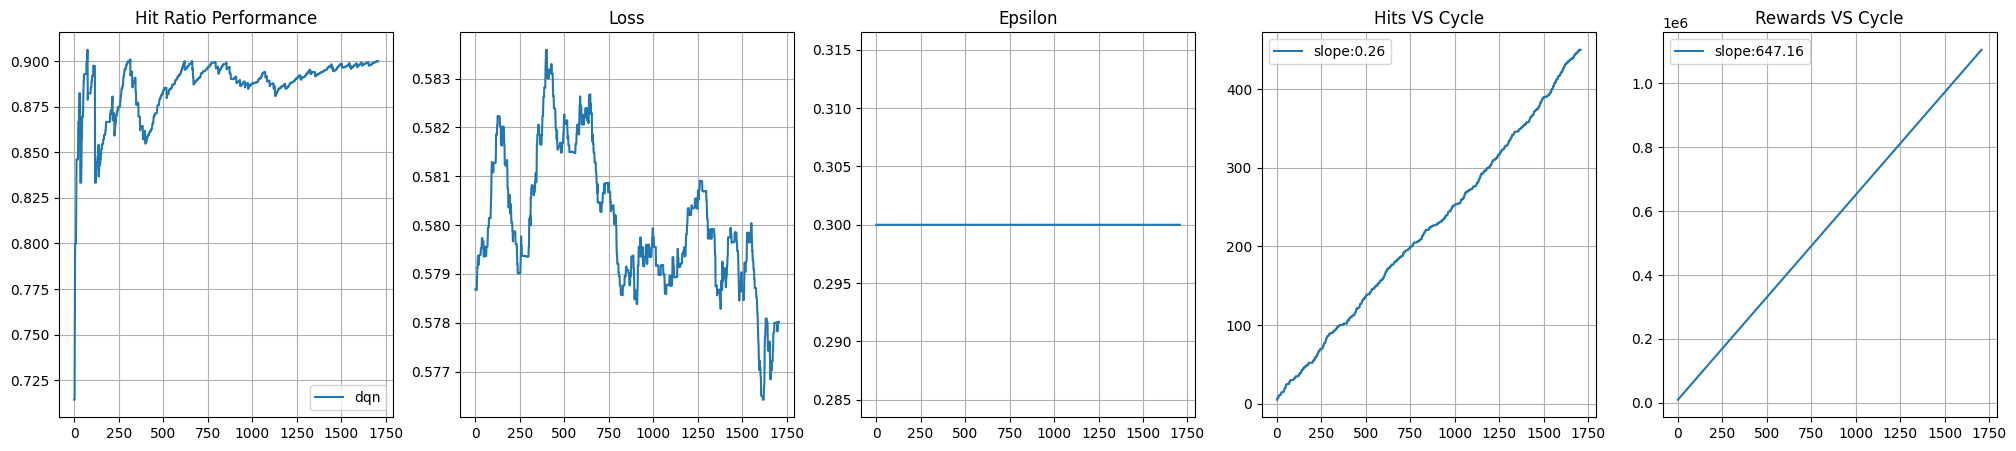

In [ ]:
training_dir = "DQN_training_sessions/"
training_sessions = []
sessions_name = []
files = os.listdir(training_dir)
dqn_exclude = [".ipynb_checkpoints"]
for exclude in dqn_exclude:
  if exclude in files:
    files.remove(exclude)
for file in files:
    training_sessions.append(joblib.load(training_dir+file))
    sessions_name.append(training_sessions[-1]["name"])

fig,ax = plt.subplots(1,5,figsize=(25,5))

for train in training_sessions:
    window_size = ws = int(no_epochs*0.3)
    weights = np.ones(window_size)/window_size
    loss__ = np.array([loss_.detach().numpy() for loss_ in train["history"]["loss"]])
    loss__ = np.convolve(loss__,weights)
    hits_epoch_slope_ = train["PERFORMANCE"]["hits_epoch_slope"]
    rewards_epoch_slope_ = train["PERFORMANCE"]["rewards_epoch_slope"]
    ax.flatten()[0].plot(np.linspace(0,train["PARAMS"]["no_epochs"],train["PARAMS"]["no_epochs"]),train["history"]["hit_ratio"],label=train["name"])
    ax.flatten()[1].plot(np.linspace(0,train["PARAMS"]["no_epochs"],len(loss__[ws:-1*ws])),1-loss__[ws:-1*ws])
    ax.flatten()[2].plot(np.linspace(0,train["PARAMS"]["no_epochs"],train["PARAMS"]["no_epochs"]),train["history"]["epsilon"])
    ax.flatten()[3].plot(np.linspace(0,train["PARAMS"]["no_epochs"],train["PARAMS"]["no_epochs"]),train["history"]["hits"],label=f"slope:{hits_epoch_slope_:.2f}")
    ax.flatten()[4].plot(np.linspace(0,train["PARAMS"]["no_epochs"],train["PARAMS"]["no_epochs"]),train["history"]["rewards"],label=f"slope:{rewards_epoch_slope_:.2f}")

    for i in range(5):
        ax.flatten()[i].grid()

    ax.flatten()[0].set_title("Hit Ratio Performance")
    ax.flatten()[1].set_title("Loss")
    ax.flatten()[2].set_title("Epsilon")
    ax.flatten()[3].set_title("Hits VS Cycle")
    ax.flatten()[4].set_title("Rewards VS Cycle")
ax.flatten()[0].legend()
ax.flatten()[3].legend()
ax.flatten()[4].legend()

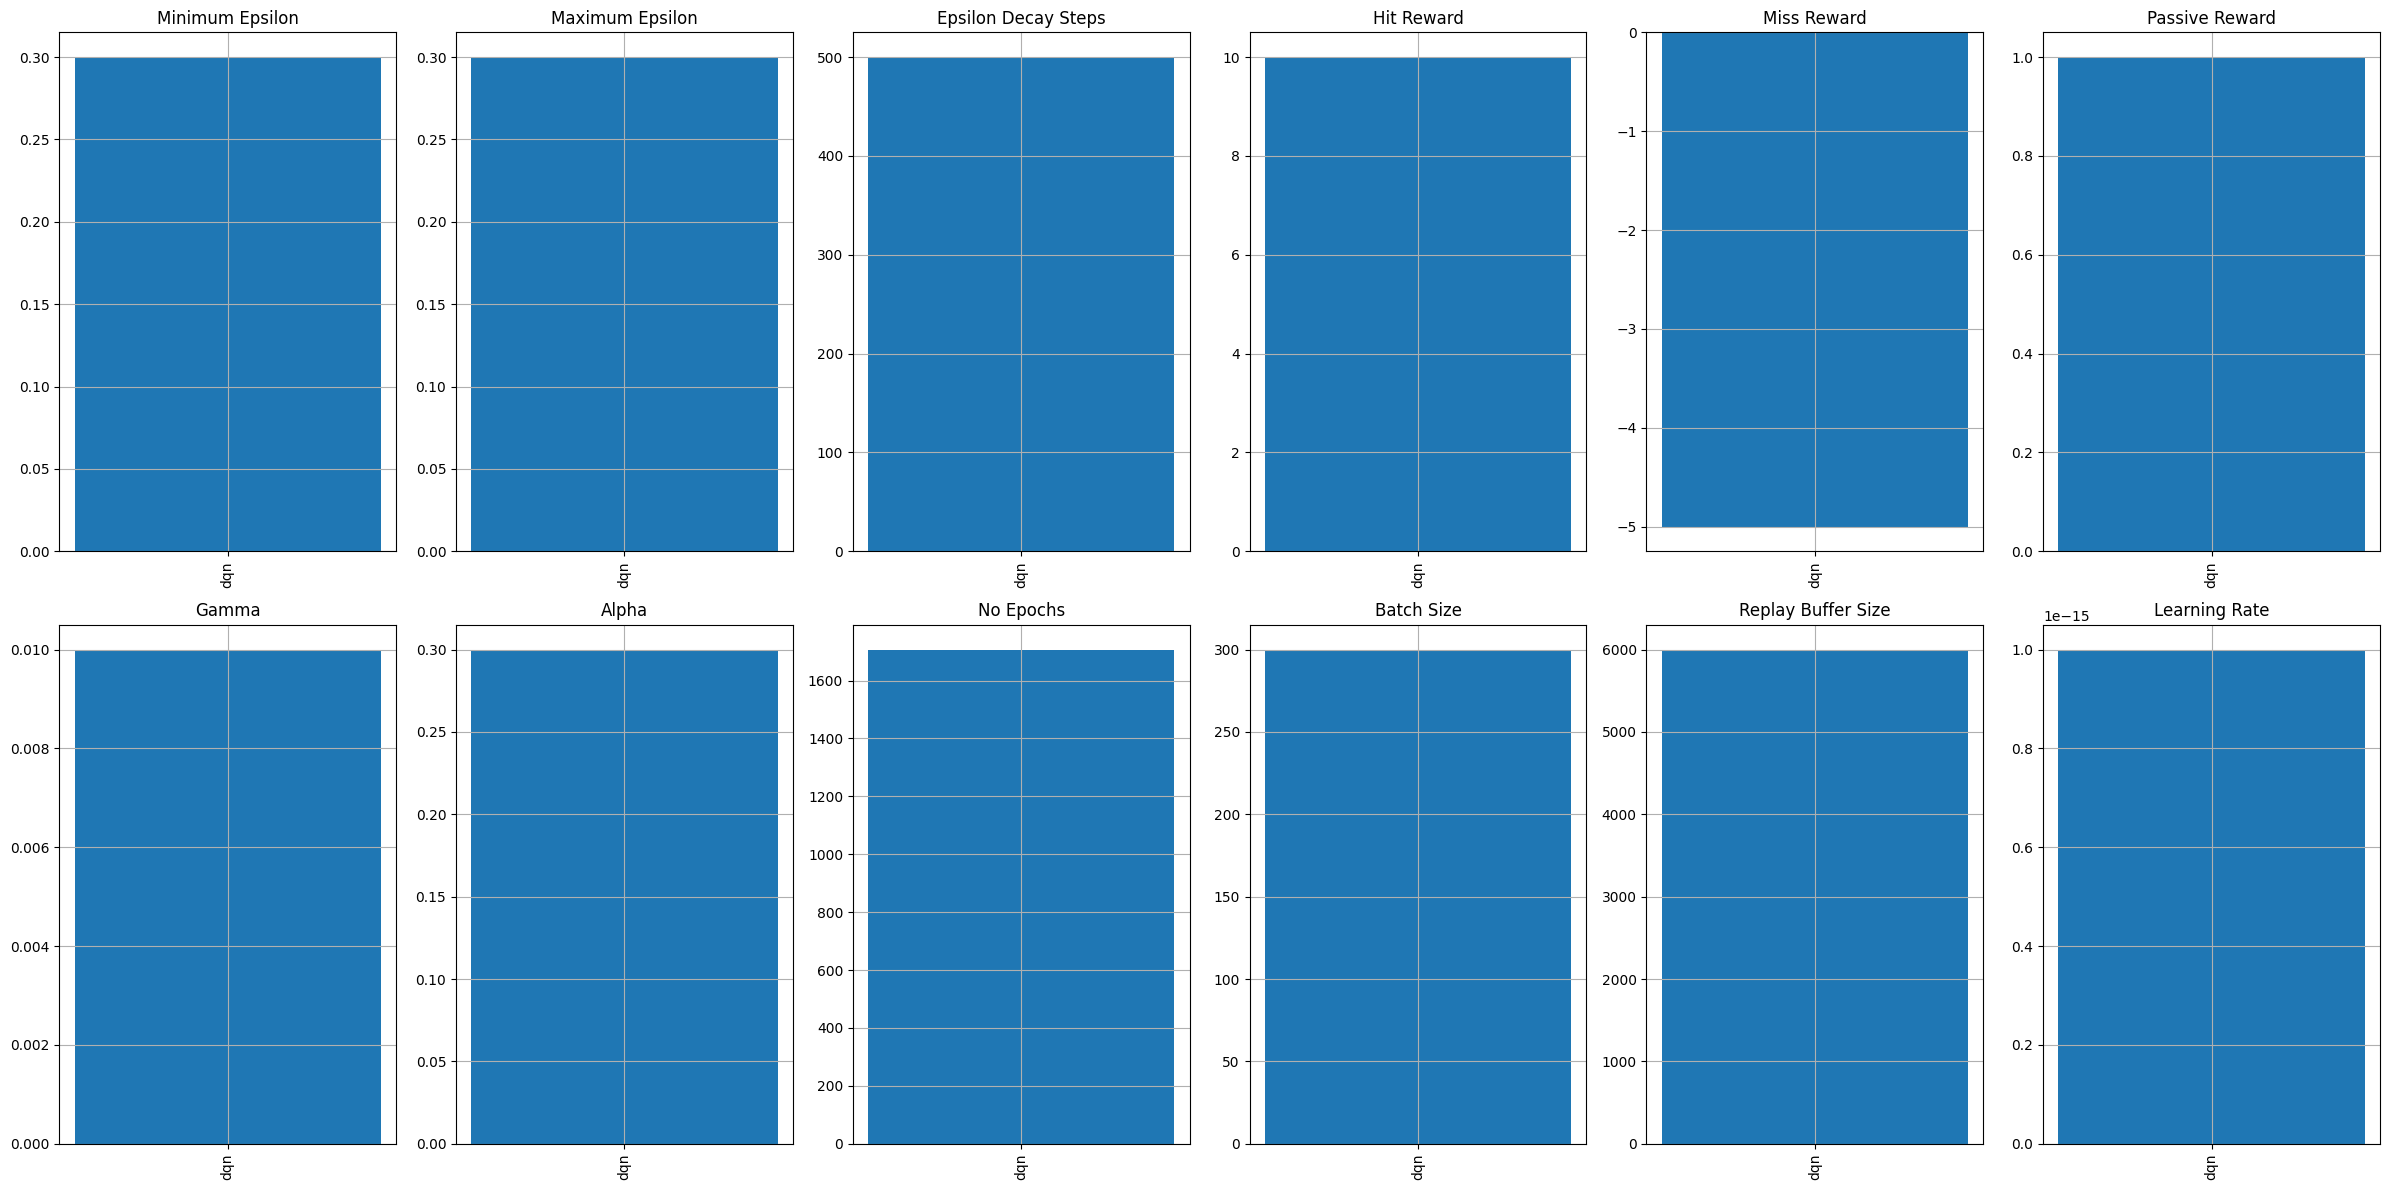

In [ ]:
fig, ax = plt.subplots(2,6,figsize=(24,12))

min_epsilon = [train["PARAMS"]["epsilon"][0] for train in training_sessions]
max_epsilon = [train["PARAMS"]["epsilon"][1] for train in training_sessions]
eps_decay_steps = [train["PARAMS"]["epsilon"][2] for train in training_sessions]
hit_reward = [train["PARAMS"]["reward"][0] for train in training_sessions]
miss_reward = [train["PARAMS"]["reward"][1] for train in training_sessions]
passive_reward = [train["PARAMS"]["reward"][2] for train in training_sessions]
gamma_ = [train["PARAMS"]["gamma"] for train in training_sessions]
alpha_ = [train["PARAMS"]["alpha"] for train in training_sessions]
no_epochs_ = [train["PARAMS"]["no_epochs"] for train in training_sessions]
batch_size_ = [train["PARAMS"]["batch_size"] for train in training_sessions]
replay_size_ = [train["PARAMS"]["replay_buffer_size"] for train in training_sessions]
learning_rate_ = [train["learning_rate"] for train in training_sessions]


for train in training_sessions:
    for p,param in enumerate([min_epsilon,max_epsilon,eps_decay_steps,hit_reward,miss_reward,passive_reward,gamma_,alpha_,no_epochs_,batch_size,\
        replay_size_,learning_rate_]):
        ax.flatten()[p].bar(sessions_name,param,label=sessions_name)
        ax.flatten()[p].tick_params(axis='x', labelrotation=90)
        ax.flatten()[p].grid()

for t,title in enumerate(["Minimum Epsilon","Maximum Epsilon","Epsilon Decay Steps","Hit Reward","Miss Reward","Passive Reward",\
    "Gamma","Alpha","No Epochs","Batch Size","Replay Buffer Size","Learning Rate"]):
    ax.flatten()[t].set_title(title)

fig.tight_layout()


In [ ]:
sessions_name

['dqn']

In [ ]:
[train["Q-Network"] for train in training_sessions]

[cnn(
   (conv): Sequential(
     (0): Conv1d(1, 5, kernel_size=(2,), stride=(1,))
     (1): ReLU()
     (2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
     (3): Conv1d(5, 15, kernel_size=(1,), stride=(1,))
     (4): ReLU()
     (5): AvgPool1d(kernel_size=(2,), stride=(1,), padding=(1,))
   )
   (fc): Sequential(
     (0): Linear(in_features=60, out_features=300, bias=True)
     (1): Sigmoid()
     (2): Linear(in_features=300, out_features=100, bias=True)
     (3): Sigmoid()
     (4): Linear(in_features=100, out_features=3, bias=True)
     (5): Sigmoid()
   )
 )]